In [1]:
# Regression Models
%matplotlib inline
#%matplotlib widget
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from collections import Counter
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor,
RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report,
f1_score, silhouette_score, adjusted_rand_score)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [2]:
df = pd.read_csv('supply_chain_deliveries.csv', engine='pyarrow')
df.head()

,WorkDate,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue
0,2020-01-02,Amazon,Chicago,Final Mile,38,190,2084.09
1,2020-01-02,Home Depot,Sacramento,Final Mile,34,136,6153.01
2,2020-01-02,Home Depot,Chicago,Final Mile,43,215,15691.72
3,2020-01-02,Home Depot,Detroit,Final Mile,41,164,6490.39
4,2020-01-02,Home Depot,Atlanta,Final Mile,44,220,10069.65


In [3]:
# Lowering columns
df.columns = df.columns.str.lower()

In [6]:
# Rename columns
df.rename(columns={'businesstype':'business_type', 'ordercount':'order_count',
                   'numberofpieces':'number_of_pieces', 'totalrevenue':'total_revenue'}, inplace=True) 

In [26]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")
print('-' * 127)

missing_values = df.isna().sum()
#today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works
#date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())
#missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

print('-' * 127)

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (126255, 7)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['workdate', 'customer', 'location', 'business_type', 'order_count', 'number_of_pieces', 'total_revenue']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126255 entries, 0 to 126254
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   workdate          126255 non-null  object 
 1   customer          126255 non-null  object 
 2   location          126255 non-null  object 
 3   business_type     126255 non-null  object 
 4   order_count       126255 non-null 

In [14]:
aggregated_data = df.groupby(['customer', 'total_revenue']).agg(
    total_revenue=('total_revenue', 'sum'),
    avg_revenue=('total_revenue', 'mean'))
aggregated_data

total_revenue  avg_revenue
customer total_revenue                            
Amazon   64.67                 323.35        64.67
         70.16                  70.16        70.16
         80.18                  80.18        80.18
         80.84                1455.12        80.84
         86.23                 517.38        86.23
...                               ...          ...
Walmart  17670.34            53011.02     17670.34
         19083.96            76335.84     19083.96
         19131.08            19131.08     19131.08
         20497.59            40995.18     20497.59
         23913.85            23913.85     23913.85

[12492 rows x 2 columns]

In [15]:
# Multiple statistics
df.groupby('customer')['total_revenue'].agg(['sum', 'mean', 'count'])

,sum,mean,count
customer,,,
Amazon,5.045422e+07,2170.073880,23250
Chick-Fil-A,4.379406e+06,1458.829600,3002
Chipotle,1.030156e+07,1551.907950,6638
Costco,3.521400e+07,1853.563601,18998
Home Depot,1.163691e+08,7878.747112,14770
Home Goods,1.021177e+07,1287.738421,7930
Lowes,1.556474e+07,3266.471473,4765
Shein,2.153992e+07,2176.629237,9896
Starbucks,2.267131e+07,1681.723352,13481


In [21]:
# Group by multiple columns
total_sales = df.groupby(['customer', 'location'])[['total_revenue']].sum().sort_values(by='total_revenue')

In [25]:
# Group by multiple columns
df.groupby(['customer', 'location', 'business_type'])[['total_revenue']].sum().sort_values(by='total_revenue')

total_revenue
customer    location      business_type               
Chipotle    Detroit       Final Mile         212512.42
Starbucks   Tampa Bay     Middle Mile        285601.73
Shein       Los Angeles   Middle Mile        311818.20
Chick-Fil-A San Francisco Final Mile         371842.04
Starbucks   Sacramento    Middle Mile        530069.51
...                                                ...
Home Depot  Atlanta       Final Mile       10257679.62
            San Francisco Final Mile       10907372.70
            Houston       Final Mile       11352085.91
            Los Angeles   Final Mile       15262085.80
            Chicago       Final Mile       15859660.58

[119 rows x 1 columns]

In [30]:
# Value_counts - Unique
objects = df.select_dtypes(include=['object','category'])
for col in objects.columns:
    #print(f"\n{col}:")
    print(f"{'='*127}")
    print(df[col].value_counts())

workdate
2020-08-13    81
2023-04-05    79
2020-07-21    78
2020-11-12    77
2020-09-19    77
              ..
2023-02-19    50
2020-04-18    49
2022-12-07    49
2023-04-12    48
2023-01-09    48
Name: count, Length: 1987, dtype: int64
customer
Amazon         23250
Costco         18998
Target         15318
Home Depot     14770
Starbucks      13481
Shein           9896
Home Goods      7930
Chipotle        6638
Walmart         5078
Lowes           4765
T.J. Maxx       3129
Chick-Fil-A     3002
Name: count, dtype: int64
location
Chicago          12079
Milwaukee         9679
Los Angeles       9296
Sacramento        9126
Detroit           8594
San Francisco     8199
Tampa Bay         8002
Houston           7815
New York          7813
Dallas            7687
Nashville         7081
Atlanta           6796
Seattle           5605
Birmingham        5563
San Diego         4739
Miami             4382
Minneapolis       3799
Name: count, dtype: int64
business_type
Middle Mile    54832
Final Mile     5

In [33]:
# Value_counts - Unique
objects = df.select_dtypes(include=['int','float'])
for col in objects.columns:
    #print(f"\n{col}:")
    print(f"{'='*127}")
    print(df[col].value_counts())

order_count
8      4307
10     4201
9      4197
7      4075
11     3854
       ... 
128      14
145      14
123      10
104       7
148       5
Name: count, Length: 138, dtype: int64
number_of_pieces
60     3547
40     3506
30     3111
45     2970
50     2866
       ... 
721       1
749       1
856       1
987       1
94        1
Name: count, Length: 469, dtype: int64
total_revenue
810.01     114
1353.61    107
676.81     106
417.68     103
312.32     102
          ... 
212.23       1
696.25       1
1478.89      1
466.01       1
9141.93      1
Name: count, Length: 12377, dtype: int64


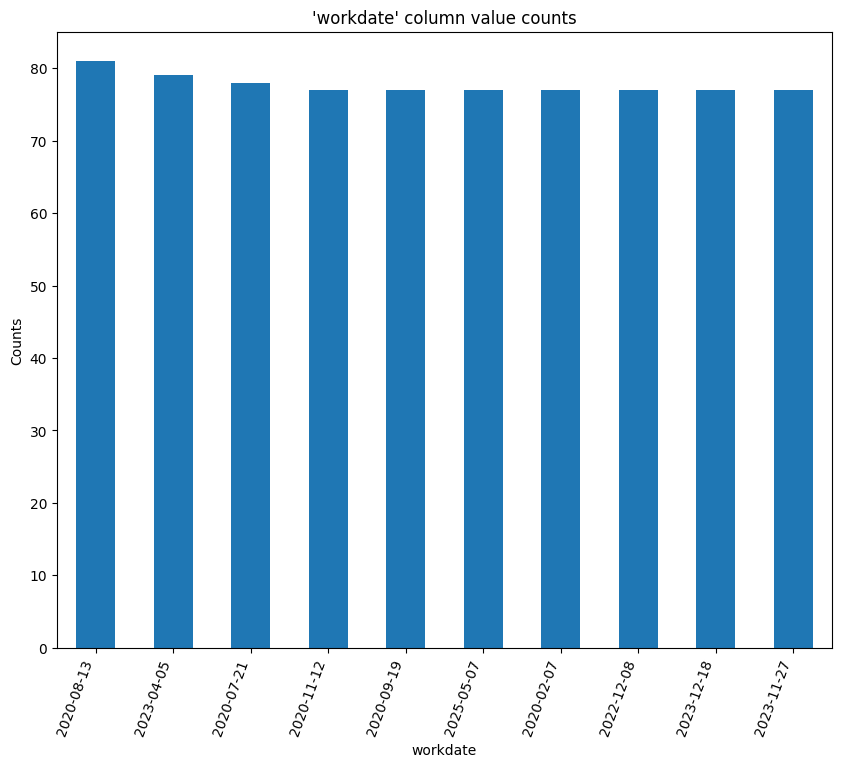

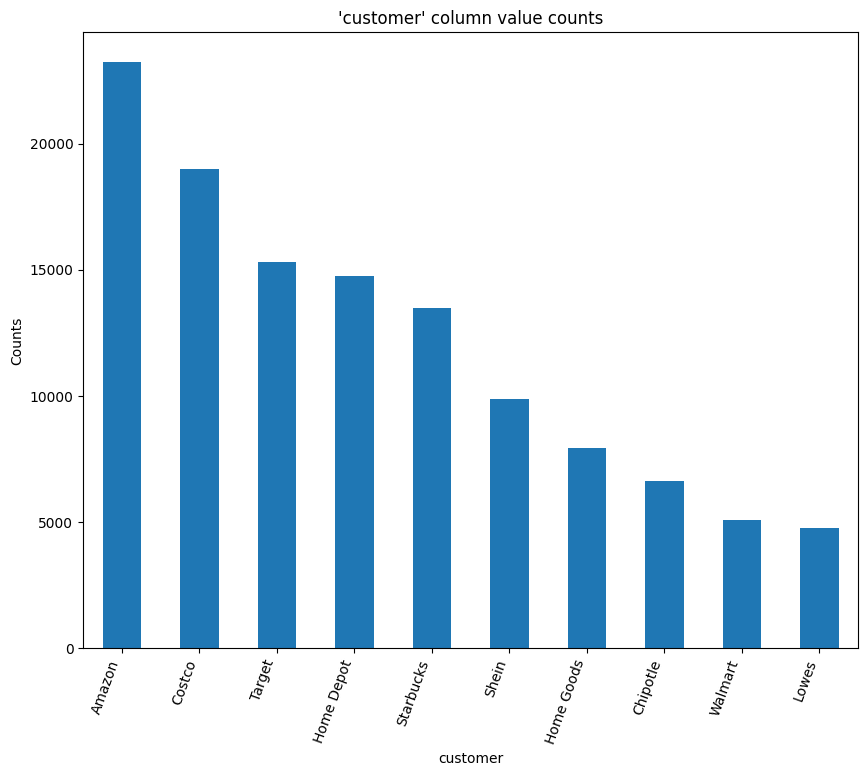

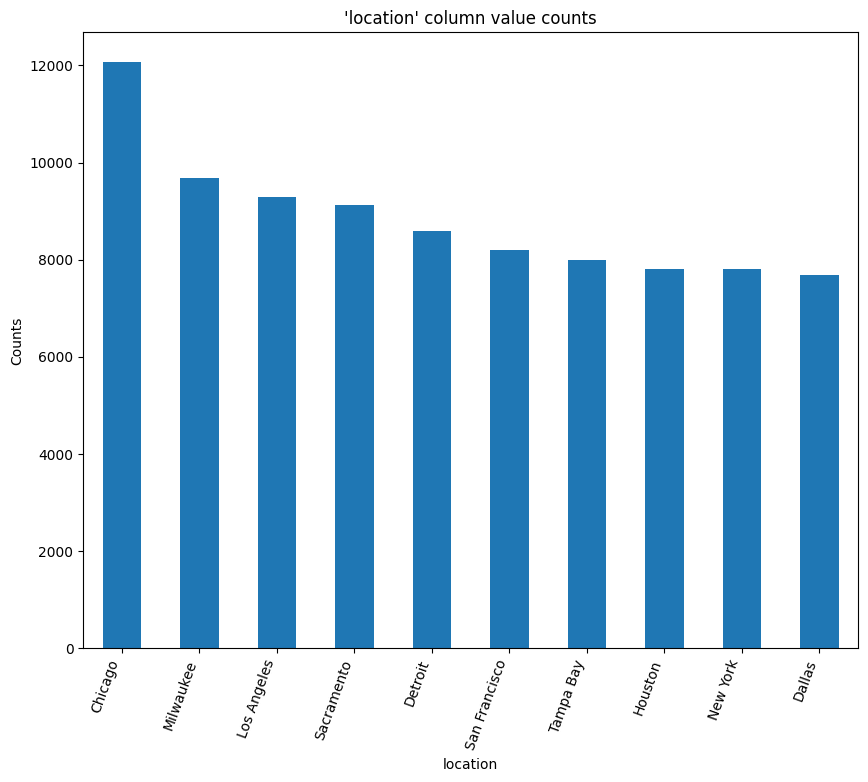

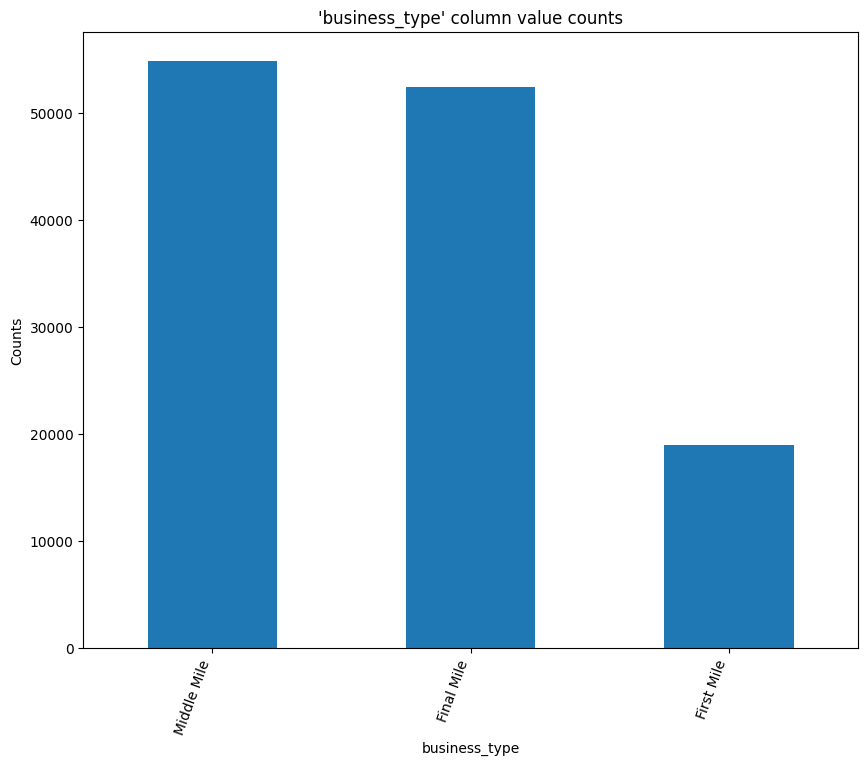

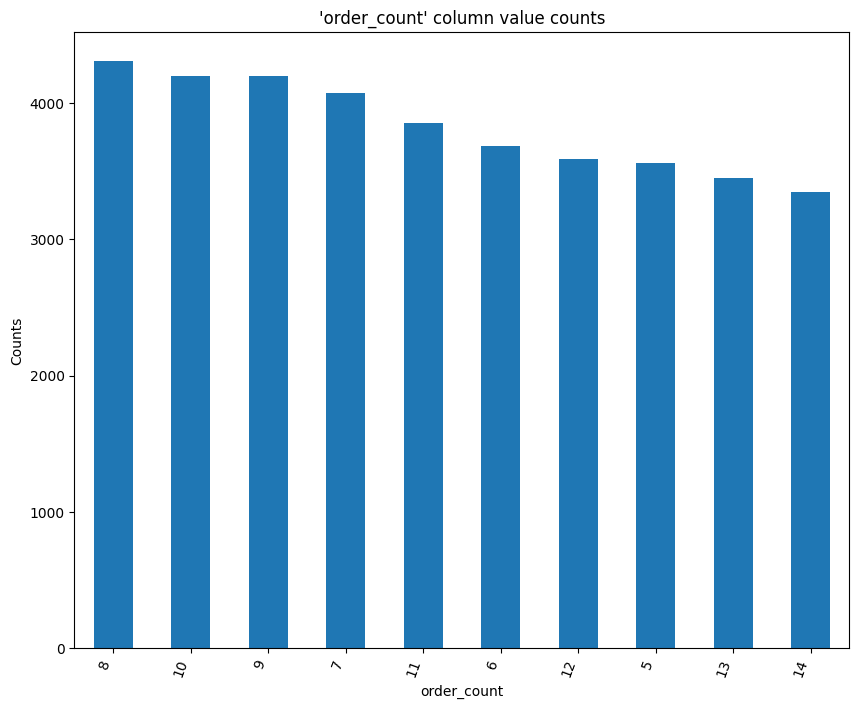

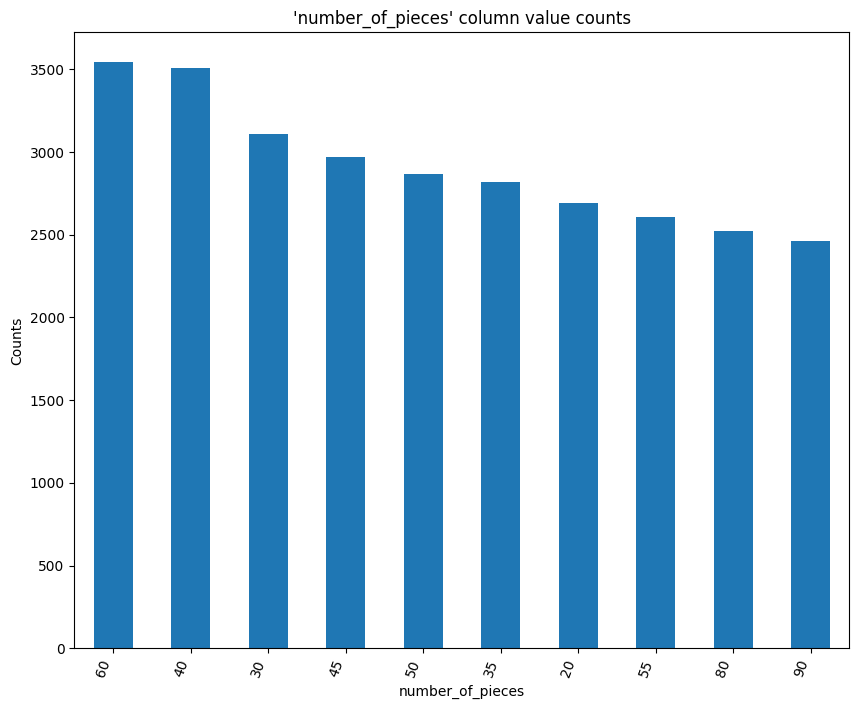

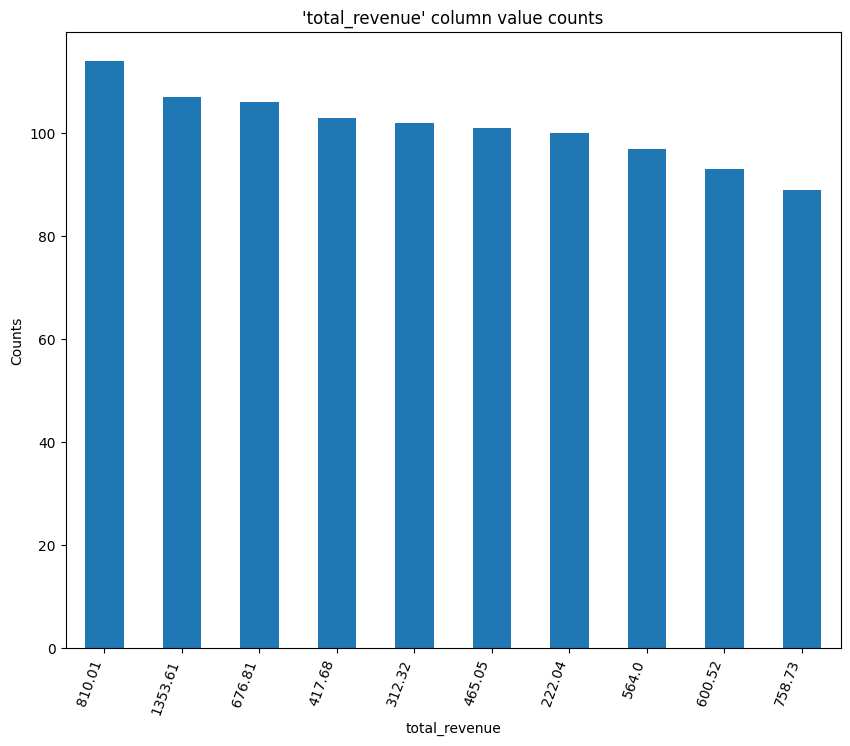

In [34]:
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

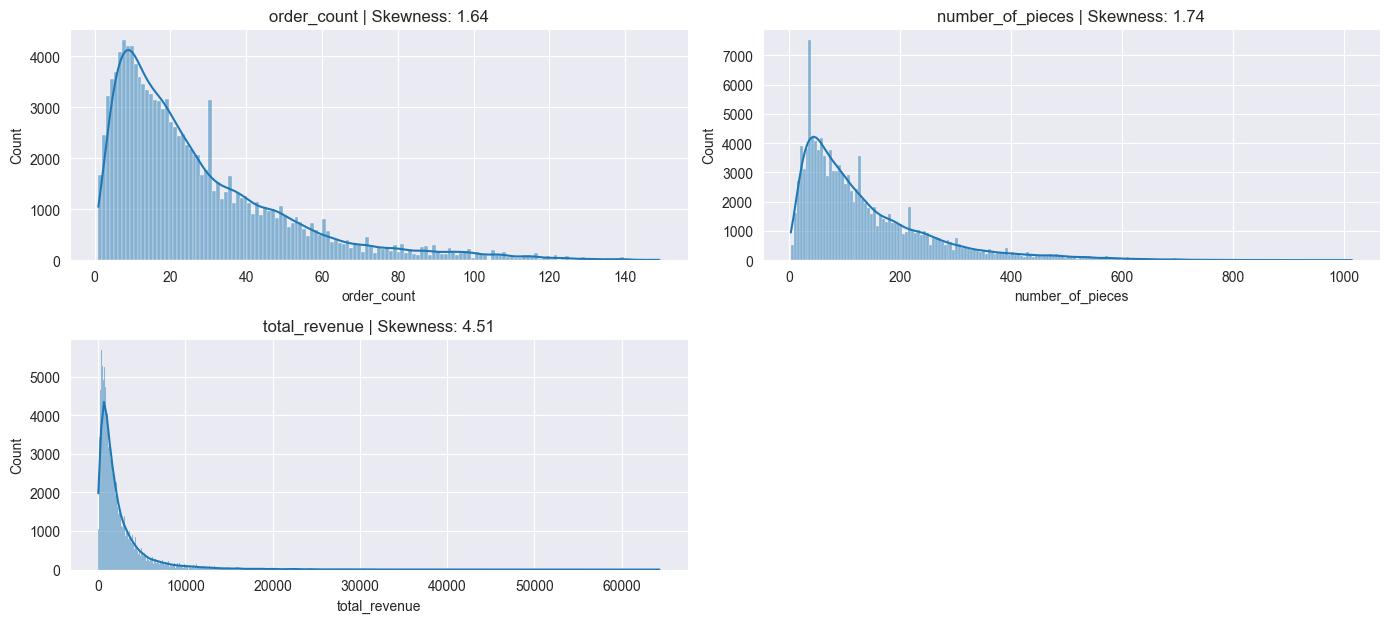

In [35]:
# Kernel Density Plot for understanding variance in the dataset
sns.set_style("darkgrid")
numerical_columns = df.select_dtypes(include=["int", "float"]).columns 
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

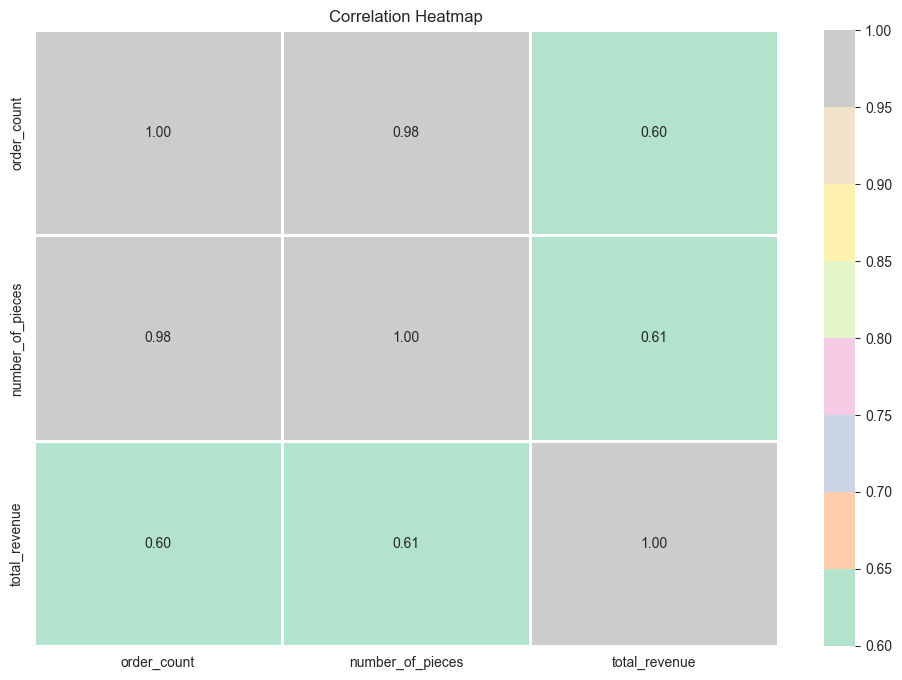

In [37]:
# Correlation Matrix for examining the correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, 
            fmt='.2f', cmap='Pastel2', linewidths=2)
plt.title('Correlation Heatmap')
plt.show() 

In [38]:
df['location'].unique()

array(['Chicago', 'Sacramento', 'Detroit', 'Atlanta', 'Houston',
       'Seattle', 'San Francisco', 'Los Angeles', 'Birmingham',
       'Tampa Bay', 'Dallas', 'Miami', 'Milwaukee', 'Nashville',
       'San Diego', 'Minneapolis', 'New York'], dtype=object)

In [39]:
df['business_type'].unique()

array(['Final Mile', 'Middle Mile', 'First Mile'], dtype=object)

In [41]:
df.drop(columns=['workdate'], axis=1, inplace=True)

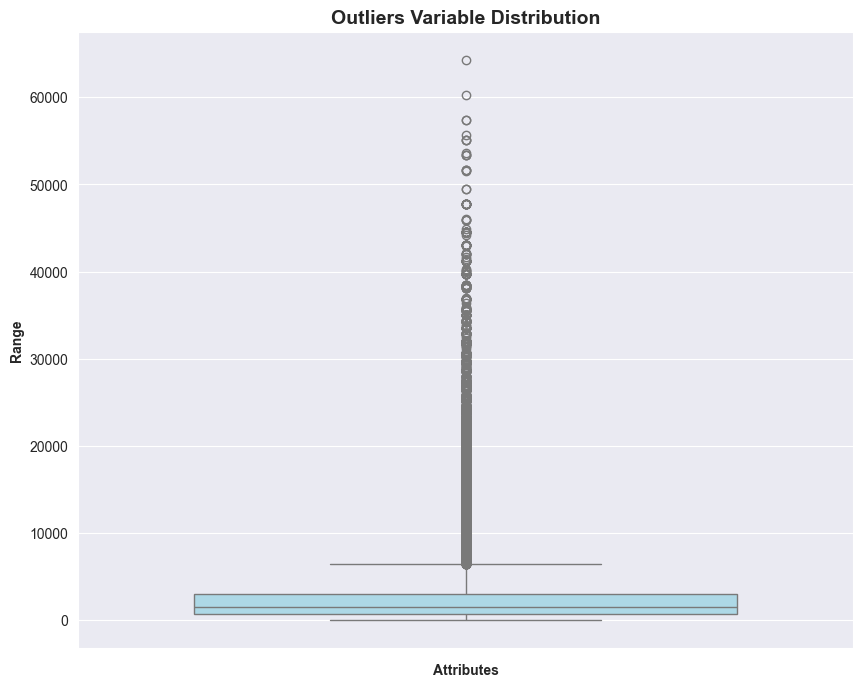

In [43]:
# Outliers
# Visualize Outlier Analysis of many columns at once
#attributes = ['Amount','Frequency','Recency']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['total_revenue'], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [103]:
df.head(2)

,order_count,number_of_pieces,customer_encoded,location_encoded,business_type_encoded,total_revenue
0,38,190,0,2,0,2084.09
6,18,72,9,15,2,730.11


In [141]:
# Removing (statistical) outliers for any column
Q1 = df.order_count.quantile(0.25)
Q3 = df.order_count.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.order_count >= Q1 - 1.5 * IQR) & (df.order_count <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers") 

# Removing (statistical) outliers for any column
Q1 = df.number_of_pieces.quantile(0.25)
Q3 = df.number_of_pieces.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.number_of_pieces >= Q1 - 1.5 * IQR) & (df.number_of_pieces <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers") 

# Removing (statistical) outliers for any column
Q1 = df.total_revenue.quantile(0.25)
Q3 = df.total_revenue.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.total_revenue >= Q1 - 1.5 * IQR) & (df.total_revenue <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers") 

Shape (89842, 6) with Outliers
Shape (89842, 6) without Outliers
Shape (89842, 6) with Outliers
Shape (89842, 6) without Outliers
Shape (89842, 6) with Outliers
Shape (89842, 6) without Outliers


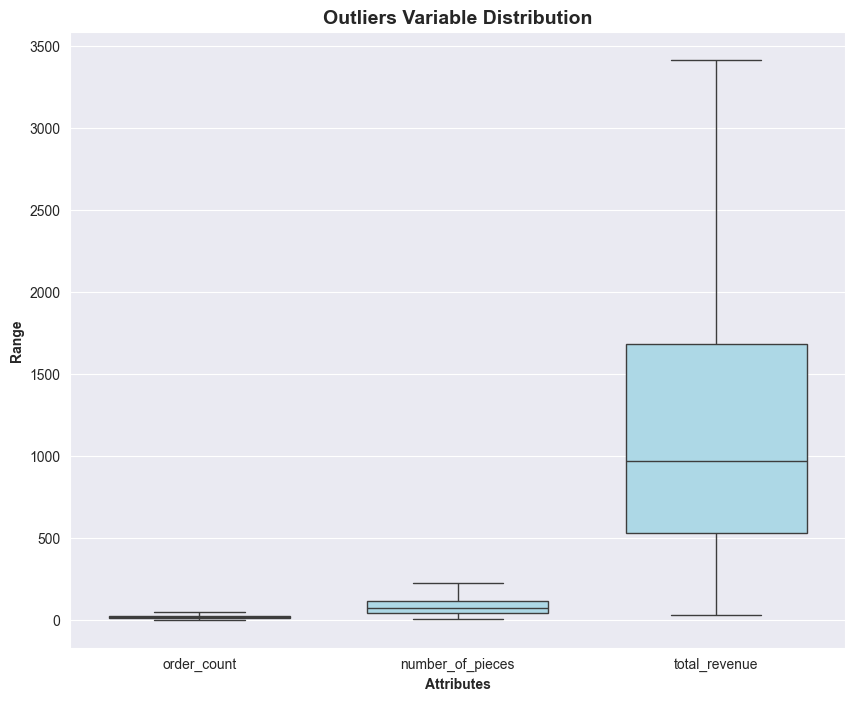

In [140]:
# Outliers
# Visualize Outlier Analysis of many columns at once
attributes = ['order_count','number_of_pieces','total_revenue']

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df[attributes], orient="v",  color="lightblue",
whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

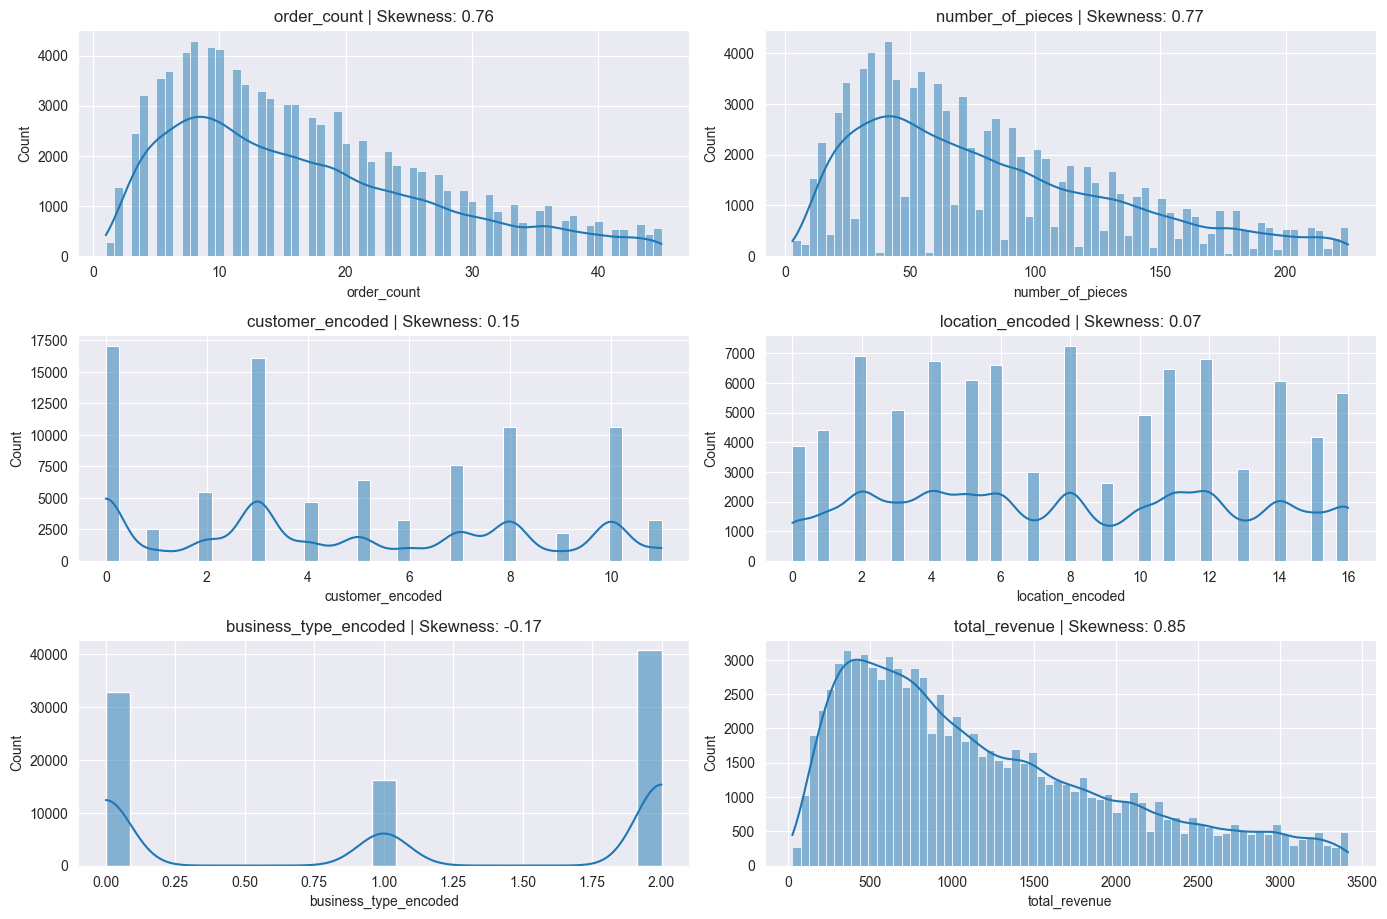

In [142]:
# Kernel Density Plot for understanding variance in the dataset
sns.set_style("darkgrid")
numerical_columns = df.select_dtypes(include=["int", "float"]).columns 
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

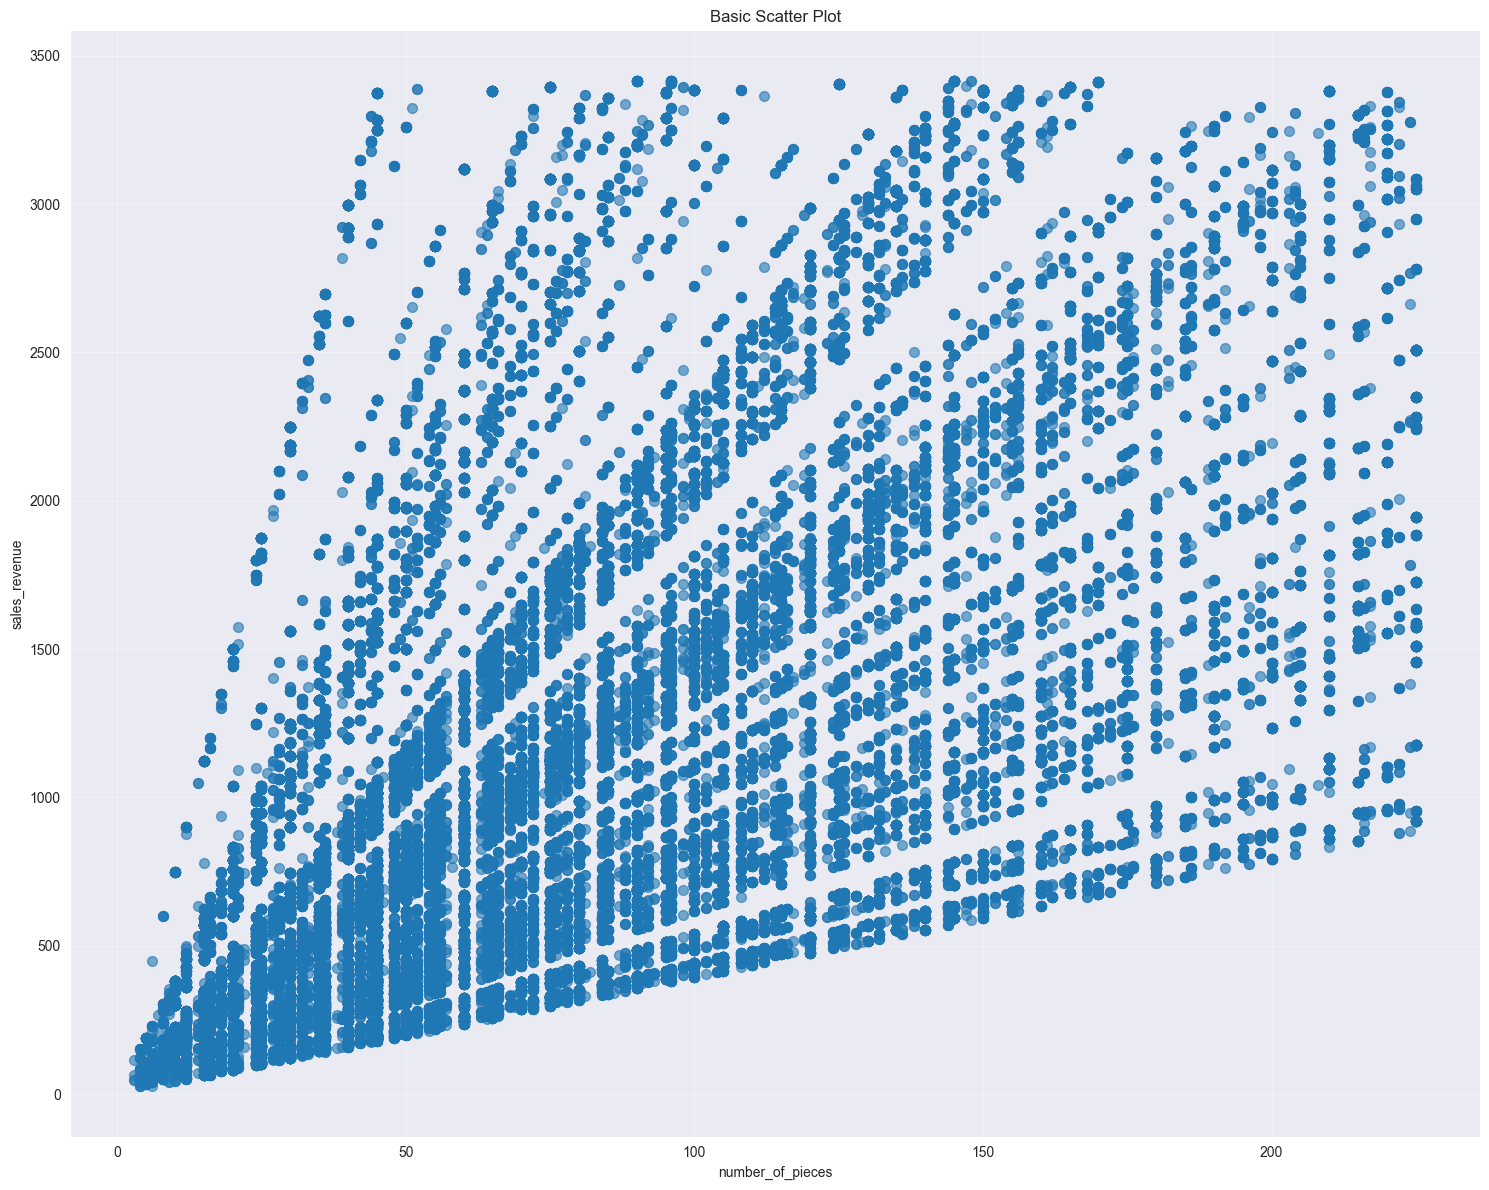

In [143]:
# Set random seed for reproducible results
np.random.seed(42)

from matplotlib.colors import ListedColormap
plt.figure(figsize=(15, 12))

# Basic scatter plot
plt.scatter(df['number_of_pieces'], df['total_revenue'], alpha=0.6, s=50)
plt.xlabel('number_of_pieces')
plt.ylabel('sales_revenue')
plt.title('Basic Scatter Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() 

In [144]:
# Imbalance
# Visualize imbalance
print(df['business_type'].value_counts())
df['business_type'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

KeyError: 'business_type'

In [81]:
# Label Encoding
# Check for categorical columns
df.select_dtypes(include=['object', 'category']).head(3) 

,customer,location,business_type
0,Amazon,Chicago,Final Mile
6,T.J. Maxx,Seattle,Middle Mile
7,T.J. Maxx,Chicago,Middle Mile


In [82]:
# Option 1: Use a loop for multiple columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

In [84]:
# Drop categorical columns
df.drop(df.select_dtypes(include=['object', 'category']), axis=1, inplace=True)

In [87]:
# shift column to first position 
first_column = df.pop('total_revenue')

# Moving the away column
df.insert(5, 'total_revenue', first_column) 

Dataset shape: (89842, 5)
Feature names: Index(['order_count', 'number_of_pieces', 'customer_encoded', 'location_encoded', 'business_type_encoded'], dtype='object')

X Train shape: (71873, 5)
Y Train shape: (71873,)
X Test shape: (17969, 5)
Y Test shape: (17969,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


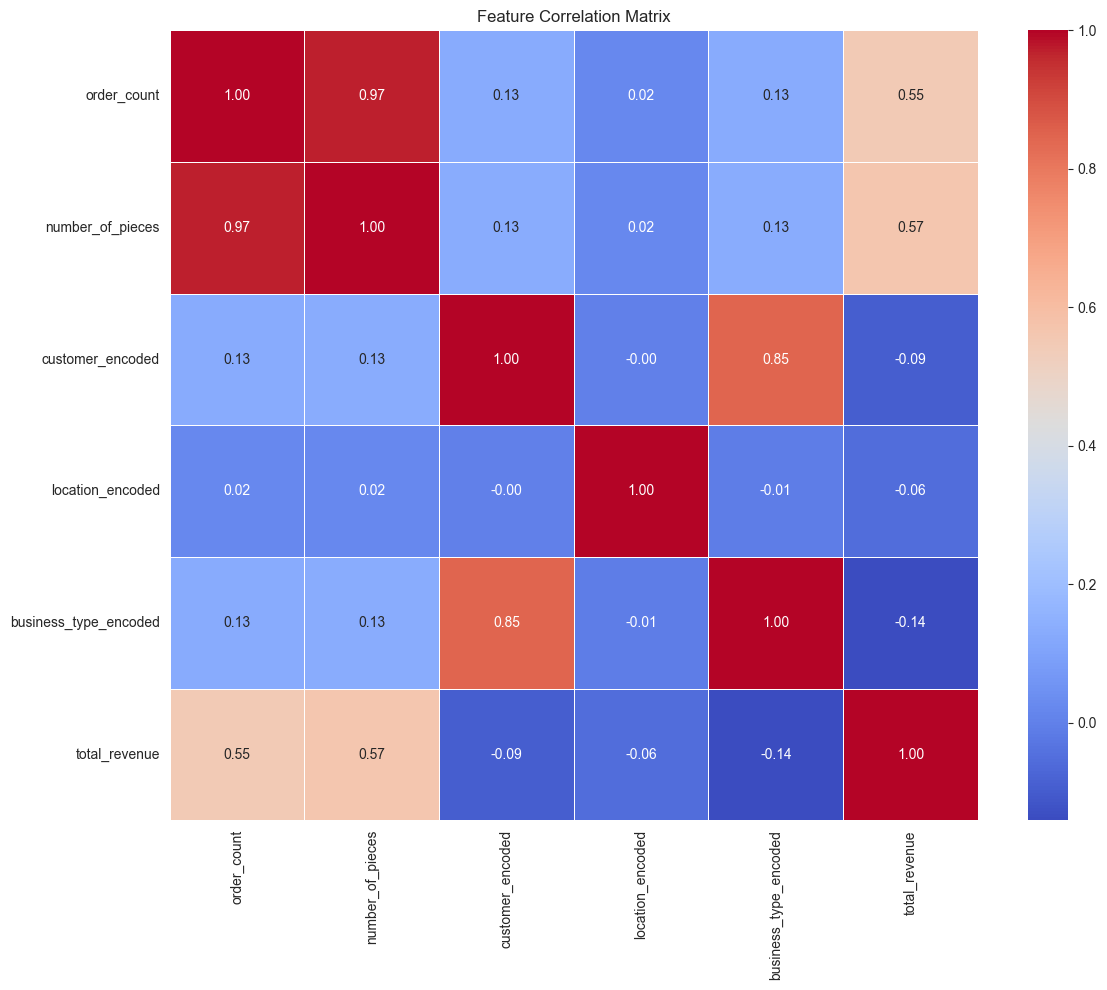

Feature correlation with target (total_revenue):
total_revenue            1.000000
number_of_pieces         0.566054
order_count              0.548126
location_encoded        -0.055649
customer_encoded        -0.093501
business_type_encoded   -0.141428
Name: total_revenue, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 416037.9017 ± 3284.9805
Cross-Validation MAE: 496.8299 ± 2.0488
Cross-Validation R²:  0.3734 ±  0.0031
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 419278.2922
MSE train set: 415173.1455

R² Score test: 0.3719
R² Score train: 0.3738

MAE test set: 499.9646
MAE train set: 495.8868

Coefficients: [  -0.33688394    9.37445002   12.15496217  -11.76475481 -240.20749184]
Intercept: 705.1096496545122

Selected 

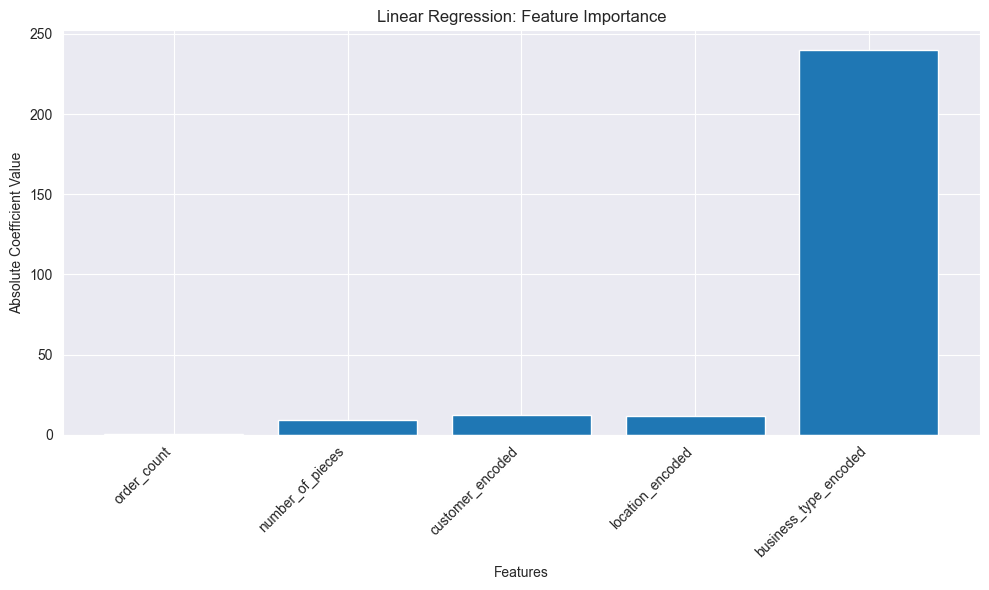

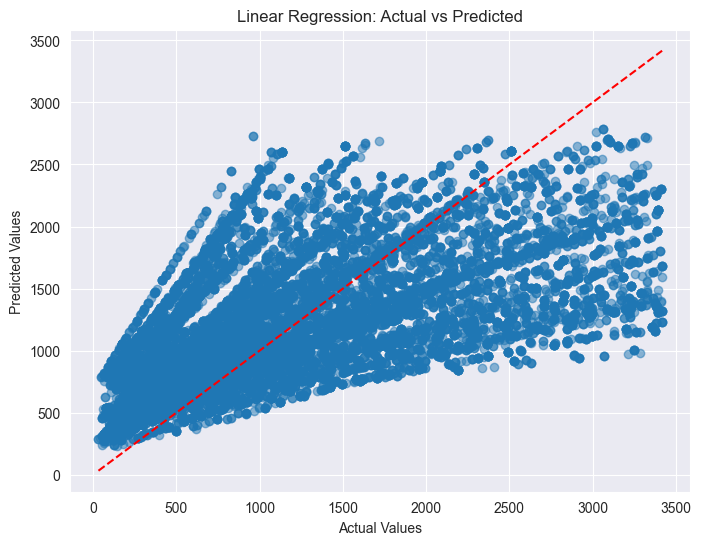

=== Scaled Linear Regression ===
MSE test set: 419278.2922
MSE train set: 415173.1455

R² Score test: 0.3719
R² Score train: 0.3738

MAE test set: 499.9646
MAE train set: 495.8868

Selected Features Coef_: ['order_count' 'number_of_pieces' 'customer_encoded' 'location_encoded'
 'business_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


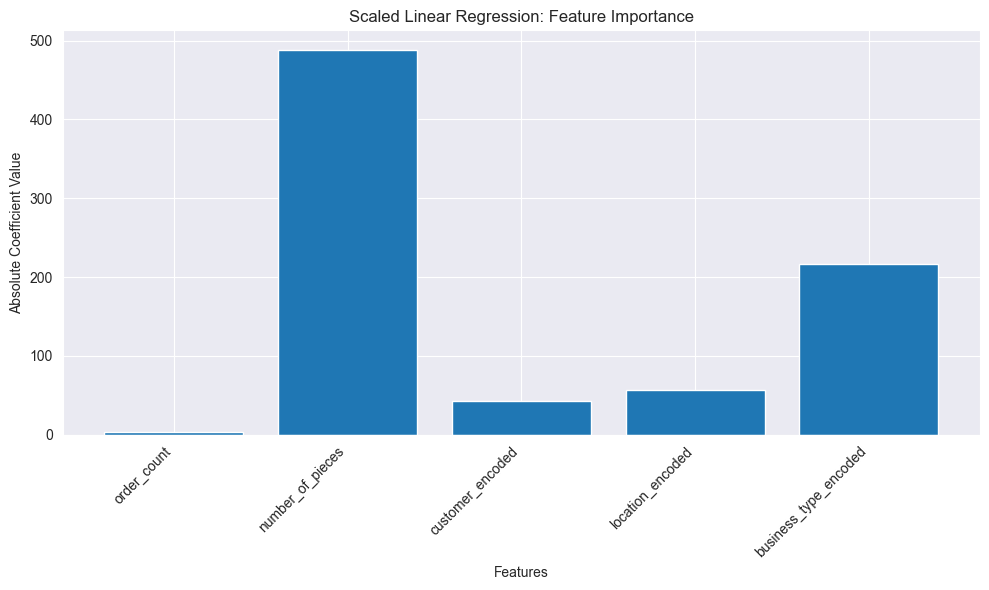

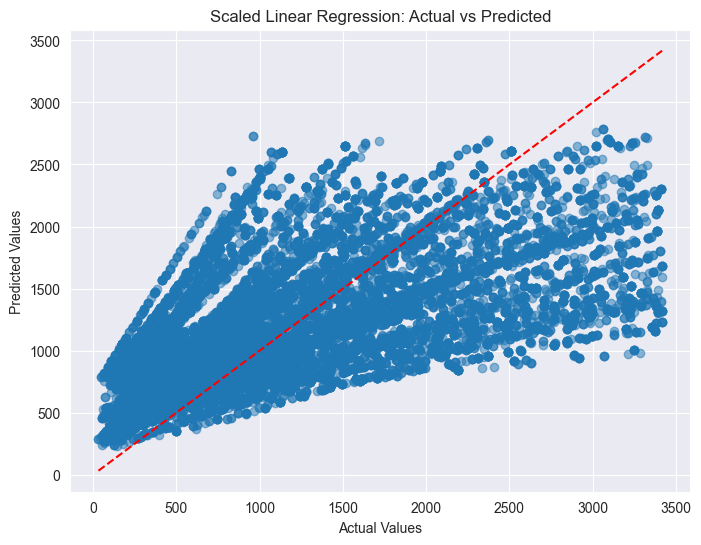

=== Feature Selection (SelectKBest) ===
MSE test set: 419278.2922
MSE train set: 415173.1455

R² Score test: 0.3719
R² Score train: 0.3738

MAE test set: 499.9646
MAE train set: 495.8868

Selected Features Selector : ['order_count' 'number_of_pieces' 'customer_encoded' 'location_encoded'
 'business_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


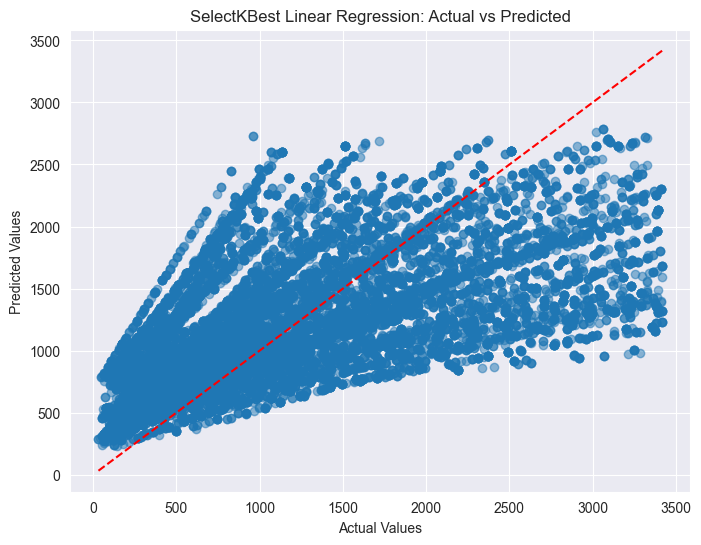

=== Feature Selection (RFE) ===
MSE test set: 419278.2922
MSE train set: 415173.1455

R² Score test: 0.3719
R² Score train: 0.3738

MAE test set: 499.9646
MAE train set: 495.8868

Selected Features Selector : ['order_count' 'number_of_pieces' 'customer_encoded' 'location_encoded'
 'business_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


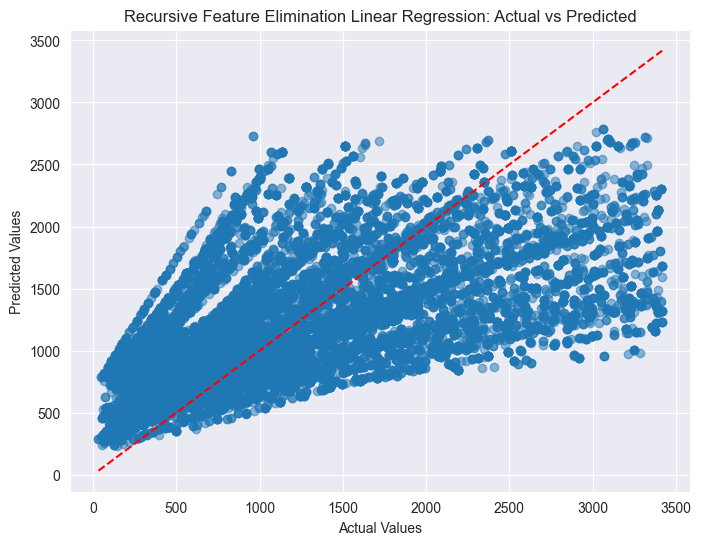

=== Polynomial Regression ===
MSE test set: 343804.5218
MSE train set: 337661.8044

R² Score test: 0.4850
R² Score train: 0.4907

MAE test set: 462.4739
MAE train set: 456.8837
-------------------------------------------------------------------------------------------------------------------------------


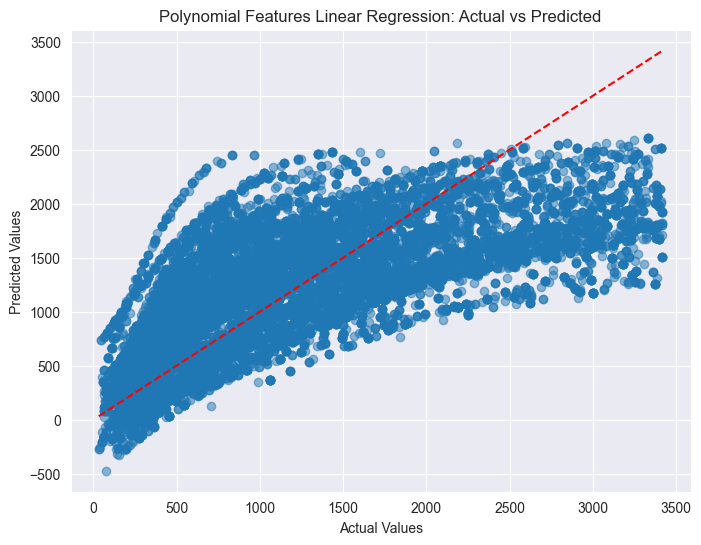

=== Ridge Regression ===
MSE test set:  419278.0559
MSE train set: 415173.1464

R² Score test: 0.3719
R² Score train:0.3738

MAE test set:  499.9653
MAE train set: 495.8877

Best alpha:    1.0000

Selected Features Coef_: ['order_count' 'number_of_pieces' 'customer_encoded' 'location_encoded'
 'business_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


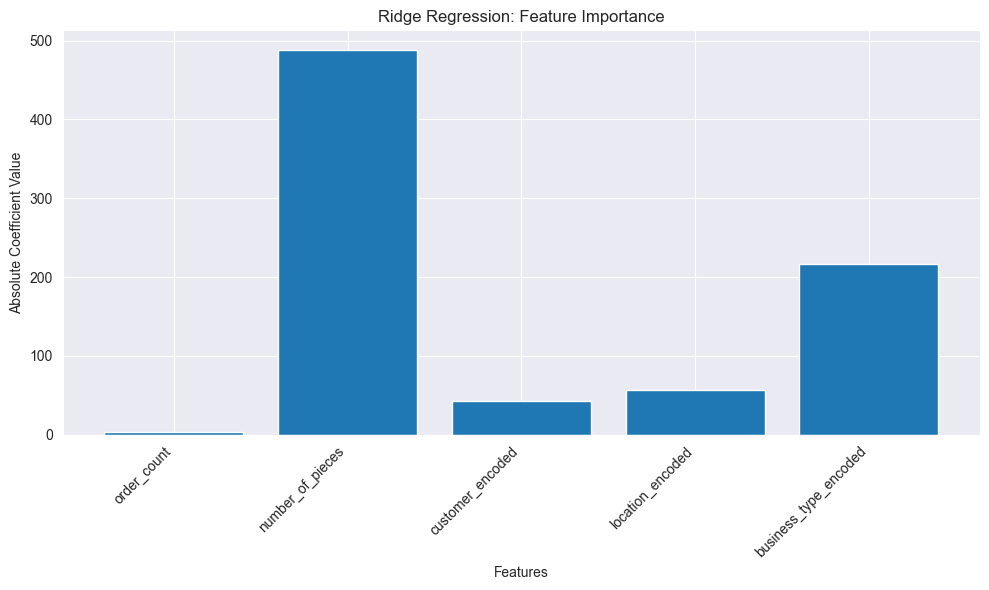

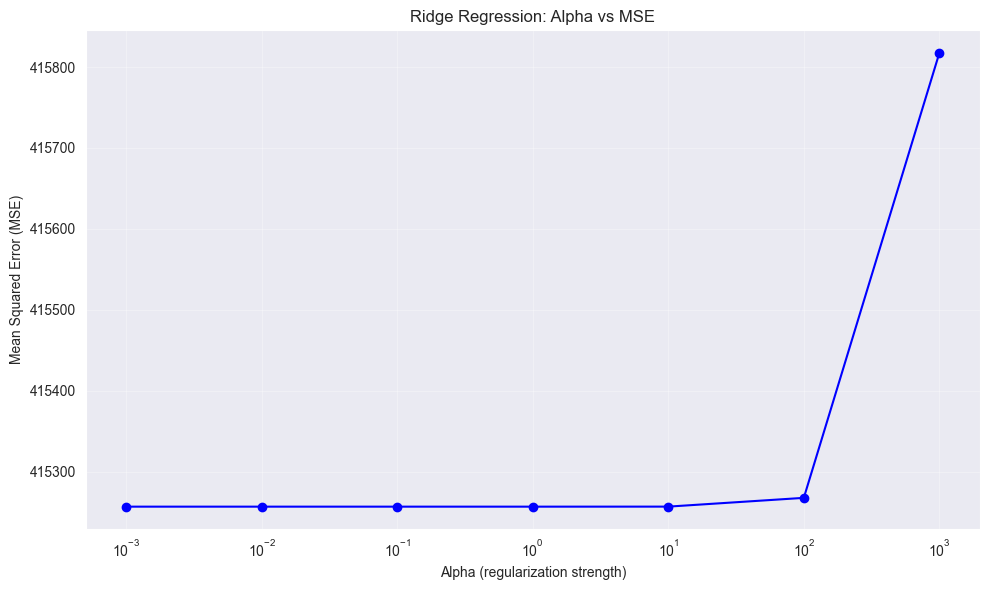

=== Lasso Regression ===
MSE test set: 419273.7619
MSE train set: 415173.9611

R² Score test: 0.3719
R² Score train: 0.3738

MAE test set: 499.9784
MAE train set: 495.9054

Best alpha: 0.1

Selected features: ['order_count' 'number_of_pieces' 'customer_encoded' 'location_encoded'
 'business_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


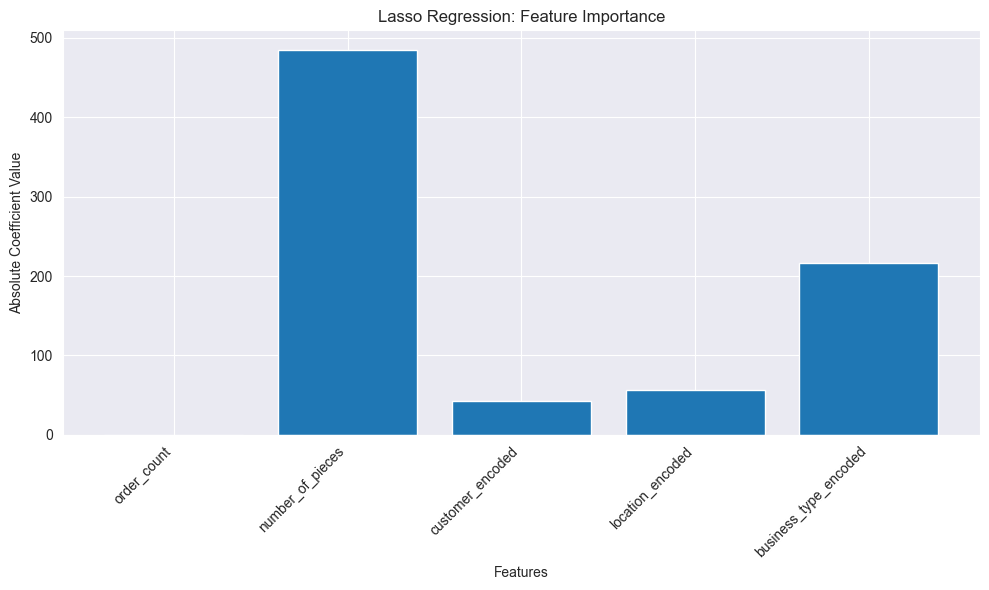

=== Elastic Net Regression ===
MSE test set: 419277.4027
MSE train set: 415173.1581

R² Score test: 0.3719
R² Score train: 0.3738

MAE test set: 499.9674
MAE train set: 495.8904

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.95}

Selected Features Coef_: ['order_count' 'number_of_pieces' 'customer_encoded' 'location_encoded'
 'business_type_encoded']
-------------------------------------------------------------------------------------------------------------------------------


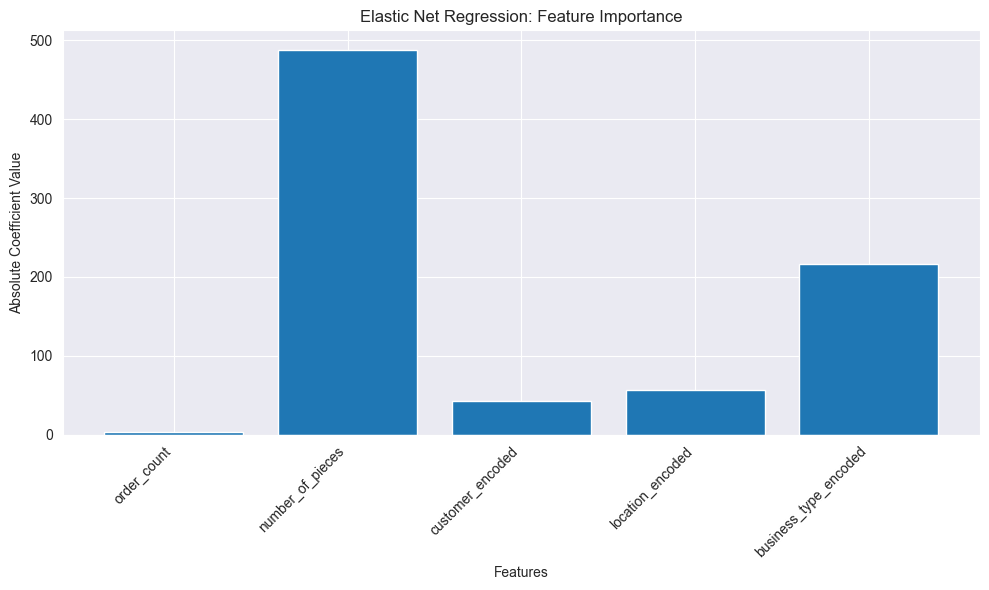

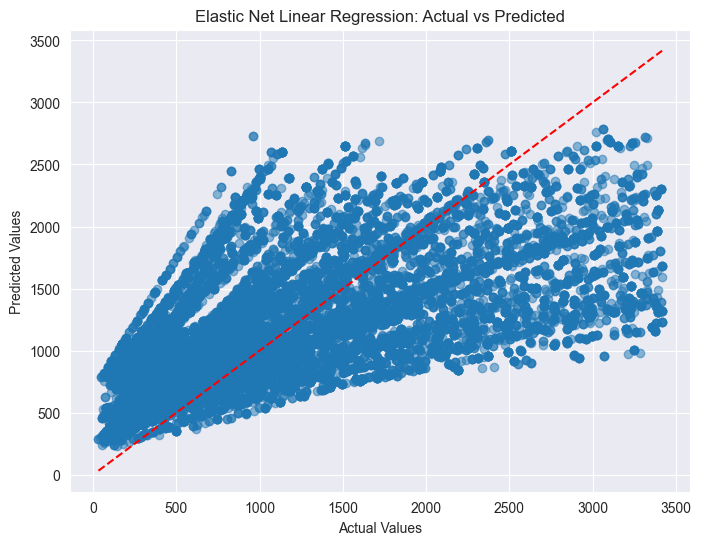

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                     MAE       MSE          R²
Polynomial Regression      343804.521842  0.484981  462.473862
Lasso Regression           419273.761923  0.371928  499.978373
Elastic Net                419277.402709  0.371923  499.967429
Ridge Regression           419278.055861  0.371922  499.965321
Basic Linear Regression    419278.292247  0.371921  499.964560
Scaled Linear Regression   419278.292247  0.371921  499.964560
Feature Selection (KBest)  419278.292247  0.371921  499.964560
Feature Selection (RFE)    419278.292247  0.371921  499.964560
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Polynomial Regression
Best model according to MSE: Polynomial Regression
Best model according to RMSE: Polynomial Regressio

In [157]:
X = df.drop(columns=['total_revenue'], axis=1)
y = df['total_revenue']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 
    print("-" * 127) 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²:  {r2_scores.mean():.4f} ±  {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }
    
    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    # Transform and transpose
    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE', ascending=False)
  
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127)  

    return results_df  
    
    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['total_revenue'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['total_revenue'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (total_revenue):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

In [147]:
df.head()

,order_count,number_of_pieces,customer_encoded,location_encoded,business_type_encoded,total_revenue
0,38,190,0,2,0,2084.09
6,18,72,9,15,2,730.11
7,33,165,9,2,2,1490.64
8,34,170,5,14,2,1199.80
9,18,90,5,2,2,1179.61
